In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
grip_thinning = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/GRIP/thinning.txt', sep='\t', comment = '#')
ngrip_thinning = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/NGRIP/thinning.txt', sep='\t', comment = '#')

load_gicc05 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05_time_scale.tab', sep='\t', comment = '#', skiprows=40)

grip_accumulation = pd.DataFrame()
#take the thickness of each year first   
grip_accumulation['thick'] = load_gicc05['Depth ice/snow [m] (GRIP)'].diff() # Calculate annual layer thickness
grip_accumulation['depth']= load_gicc05['Depth ice/snow [m] (GRIP)'] # Depth in meters
grip_accumulation.dropna(inplace=True)  # Remove NaN values resulting from diff()

grip_accumulation = grip_accumulation.dropna(subset=['thick']) # Ensure no NaN values in 'thick' column


#get density 
grip_density = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/GRIP/density.txt', sep='\t', comment = '#')
grip_density

,depth,rel_dens
0,0.000000,0.352574
1,0.203704,0.356241
2,0.407407,0.359908
3,0.611111,0.363575
4,0.814815,0.367242
...,...,...
13746,2750.139179,1.000000
13747,2750.339248,1.000000
13748,2750.539318,1.000000
13749,2750.739388,1.000000


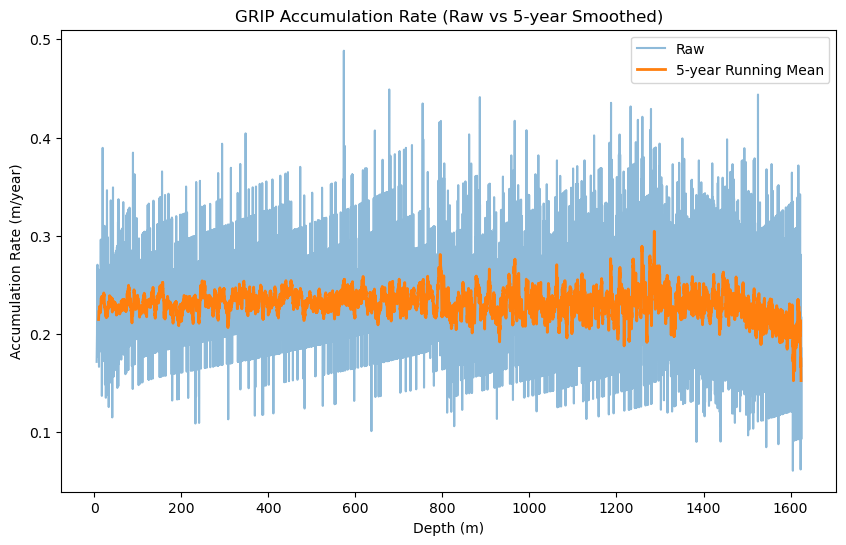

In [27]:
# acc = thickness / thinning factor
grip_accumulation['thinning'] = np.interp(grip_accumulation['depth'], grip_thinning['depth'], grip_thinning['thinning']) # Interpolate thinning factors to match depths
grip_accumulation['density'] = np.interp(grip_accumulation['depth'], grip_density['depth'], grip_density['rel_dens']) # Interpolate density to match depths

grip_accumulation['accumulation'] = (grip_accumulation['thick'] / grip_accumulation['thinning']) * grip_accumulation['density'] # Calculate accumulation rate

# running mean
grip_accumulation['accumulation_5yr'] = (
    grip_accumulation['accumulation'].rolling(window=20, center=True).mean()
)

plt.figure(figsize=(10,6))
plt.plot(grip_accumulation['depth'], grip_accumulation['accumulation'], label='Raw', alpha=0.5)
plt.plot(grip_accumulation['depth'], grip_accumulation['accumulation_5yr'], label='5-year Running Mean', linewidth=2)
plt.xlabel('Depth (m)')
plt.ylabel('Accumulation Rate (m/year)')
plt.title('GRIP Accumulation Rate (Raw vs 5-year Smoothed)')
plt.legend()
plt.show()

In [35]:
#this is a calculation of accumulation using NGRIP-GRIP tie points

ngrip_grip_ties = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/NGRIP-GRIP/iceice_synchro_horizons (full).txt', sep='\t', comment = '#', skiprows=1, names=['NGRIP', 'GRIP', "unc"])
ngrip_grip_ties = ngrip_grip_ties.where(ngrip_grip_ties['GRIP'] > grip_accumulation['depth'].max()).dropna() # Drop rows where GRIP is not greater than max depth

ngrip_grip_ties = ngrip_grip_ties.where(ngrip_grip_ties['NGRIP'] < load_gicc05['Depth ice/snow [m] (NGRIP2)'].max()).dropna() # Drop rows where there are tiepoints within the gicc ngrip2 range

#get associated NGRIP ages with GICC05
#NGRIP1 max is 1371 so this is all NGRIP2.
gicc05 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05_time_scale.tab', sep='\t', comment = '#', skiprows=40)

gicc05.dropna(inplace=True, subset=['Depth ice/snow [m] (NGRIP2)', 'Age [a] (b2k)']) # Ensure no NaN values in relevant columns
gicc05_interp = gicc05[['Age [a] (b2k)', 'Depth ice/snow [m] (NGRIP2)']]

ngrip_grip_ties['GICC05_age'] = np.interp(ngrip_grip_ties['NGRIP'], gicc05_interp['Depth ice/snow [m] (NGRIP2)'], gicc05_interp['Age [a] (b2k)'])

ngrip_grip_ties['time_diff'] = ngrip_grip_ties['GICC05_age'].diff().abs() # Calculate time differences between consecutive ties
ngrip_grip_ties['depth_diff'] = ngrip_grip_ties['GRIP'].diff().abs() # Calculate depth differences between consecutive ties

ngrip_grip_ties['annual_thickness'] = ngrip_grip_ties['depth_diff'] / ngrip_grip_ties['time_diff'] # Calculate annual layer thickness
ngrip_grip_ties = ngrip_grip_ties.dropna(subset=['annual_thickness']) # Ensure no NaN values in 'annual_thickness' column

grip_accumulation2 = ngrip_grip_ties[['annual_thickness']].copy(deep=True)
grip_accumulation2['depth'] = ngrip_grip_ties['GRIP'] # Depth in meters
grip_accumulation2['thinning'] = np.interp(grip_accumulation2['depth'], grip_thinning['depth'], grip_thinning['thinning']) # Interpolate thinning factors to match depths
grip_accumulation2['density'] = np.interp(grip_accumulation2['depth'], grip_density['depth'], grip_density['rel_dens']) # Interpolate density to match depths

grip_accumulation2['deporate'] = grip_accumulation2['annual_thickness'] / grip_accumulation2['thinning'] * grip_accumulation2['density'] # Calculate accumulation rate
grip_accumulation_export2 = grip_accumulation2[['depth', 'deporate']]
grip_accumulation_export2['rel_unc'] = grip_accumulation_export2['deporate'] * 0.15
grip_accumulation_export2['comment'] = np.nan

grip_accumulation_export2


grip_accumulation.rename(columns={
    'accumulation_5yr': 'deporate'
}, inplace=True)

grip_accumulation['rel_unc'] = grip_accumulation['deporate'] * 0.15  # 15% relative uncertainty

grip_accumulation['comment'] = np.nan

grip_accumulation_export = grip_accumulation[['depth', 'deporate', 'rel_unc', 'comment']]

grip_accumulation_export = grip_accumulation_export.iloc[::15].reset_index(drop=True) #remove 14/15 rows to thin the data

grip_accumulation_export_3 = pd.concat([grip_accumulation_export, grip_accumulation_export2], ignore_index=True)

grip_accumulation_export_3.dropna(inplace=True, subset=['deporate'])  # Ensure no NaN values in 'deporate' column
grip_accumulation_export_3

/var/folders/cd/1mh45k3j19g5g_kxkz_17xvc0000gn/T/ipykernel_4232/1477818550.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grip_accumulation_export2['rel_unc'] = grip_accumulation_export2['deporate'] * 0.15
/var/folders/cd/1mh45k3j19g5g_kxkz_17xvc0000gn/T/ipykernel_4232/1477818550.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grip_accumulation_export2['comment'] = np.nan


,depth,deporate,rel_unc,comment
1,12.100,0.221106,0.033166,NaN
2,17.825,0.238373,0.035756,NaN
3,23.525,0.232234,0.034835,NaN
4,28.550,0.224090,0.033613,NaN
5,33.400,0.229820,0.034473,NaN
...,...,...,...,...
1144,2475.174,0.226204,0.033931,NaN
1145,2476.001,0.237788,0.035668,NaN
1146,2478.222,0.120140,0.018021,NaN
1147,2478.420,0.111854,0.016778,NaN


In [36]:
#difference in sample frequency

print(len(grip_accumulation_export['depth'])/(grip_accumulation_export['depth'].max()-grip_accumulation_export['depth'].min()))

print(len(grip_accumulation_export2['depth'])/(grip_accumulation_export2['depth'].max()-grip_accumulation_export2['depth'].min()))

0.48147346951389103
0.43349638264842866


Linear Regression Results: Acc = 0.0192 * d18O + 0.9017
R-squared: 0.7914


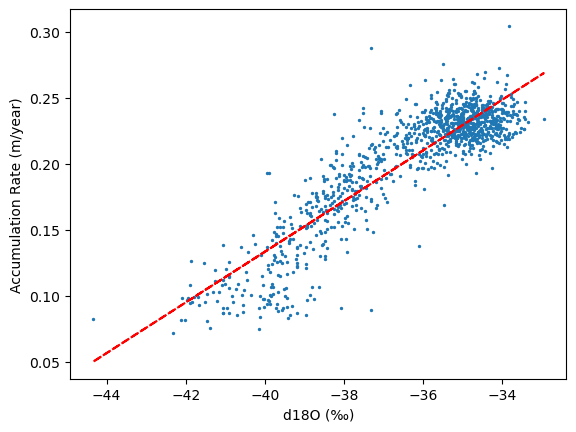

In [37]:
################################################ Isotope Calculations

from scipy.stats import linregress

#from the 2nd commented one
#grip_isotope_calc = grip_extended_chronology[['depth', 'deporate', 'd18O', 'age', 'rel_unc', 'comment']].copy(deep=True)

grip_isotope_calc = pd.read_excel('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05 match points and d18O and CH4.xlsx', sheet_name = 4, skiprows=21, usecols=[1,2,3,4], names=['depth', 'age', 'mce', 'd18O'])

grip_isotope_calc = grip_isotope_calc[1:]
grip_isotope_calc.dropna(inplace=True, subset=['depth', 'd18O']) # Ensure no NaN values in relevant column

grip_accumulation_export_3['d18O'] = np.interp(grip_accumulation_export_3['depth'], grip_isotope_calc['depth'], grip_isotope_calc['d18O']) # Interpolate d18O to match depths

grip_accumulation_export_3.dropna(inplace=True, subset=['deporate']) # Ensure no NaN values in relevant columns


plt.scatter(grip_accumulation_export_3['d18O'], grip_accumulation_export_3['deporate'], s=2)
plt.ylabel('Accumulation Rate (m/year)')
plt.xlabel('d18O (‰)')

y = grip_accumulation_export_3['deporate']
x = grip_accumulation_export_3['d18O']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"Linear Regression Results: Acc = {slope:.4f} * d18O + {intercept:.4f}")

# Plot the regression line
plt.plot(x, intercept + slope * x, 'r', label='fitted line', linestyle='--')

print(f"R-squared: {r_value**2:.4f}")

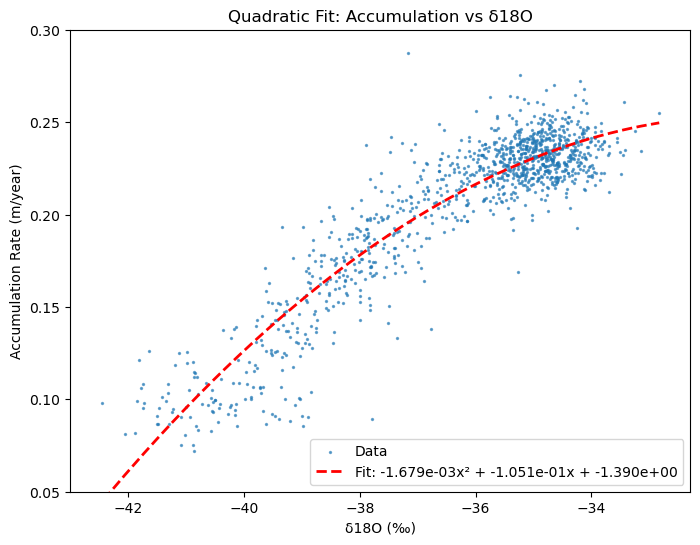

Quadratic (Binomial) Regression Results:
  deporate = -1.6787e-03x² + -1.0506e-01x + -1.3902e+00
  R² = 0.8470


In [61]:
################################################ Isotope Calculations — Quadratic (Binomial) Fit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load isotope data ---
grip_isotope_calc = pd.read_excel(
    '/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05 match points and d18O and CH4.xlsx',
    sheet_name=4,
    skiprows=21,
    usecols=[1,2,3,4],
    names=['depth', 'age', 'mce', 'd18O']
)

grip_isotope_calc = grip_isotope_calc[1:]
grip_isotope_calc.dropna(inplace=True, subset=['depth', 'd18O'])
grip_isotope_calc = grip_isotope_calc.drop_duplicates(subset='depth', keep='first').reset_index(drop=True)


# --- Interpolate isotope data to accumulation depths ---
grip_accumulation_export_3['d18O'] = np.interp(
    grip_accumulation_export_3['depth'],
    grip_isotope_calc['depth'],
    grip_isotope_calc['d18O']
)

# --- Clean data ---
grip_accumulation_export_3.dropna(subset=['deporate', 'd18O'], inplace=True)
x = grip_accumulation_export_3['d18O'].astype(float)
y = grip_accumulation_export_3['deporate'].astype(float)

# --- Fit quadratic model: deporate = a*x^2 + b*x + c ---
coeffs = np.polyfit(x, y, 2)
a, b, c = coeffs
poly_eq = np.poly1d(coeffs)

# --- Compute fitted values and R² ---
y_fit = poly_eq(x)
ss_res = np.sum((y - y_fit)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# --- Plot results ---
plt.figure(figsize=(8,6))
plt.scatter(x, y, s=2, label='Data', alpha=0.6)
x_sorted = np.sort(x)
plt.plot(x_sorted, poly_eq(x_sorted), 'r--', linewidth=2,
         label=f'Fit: {a:.3e}x² + {b:.3e}x + {c:.3e}')
plt.xlabel('δ18O (‰)')
plt.ylabel('Accumulation Rate (m/year)')
plt.title('Quadratic Fit: Accumulation vs δ18O')
plt.ylim(0.05,0.30)
plt.xlim(-43)
plt.legend()
plt.show()

# --- Print regression results ---
print("Quadratic (Binomial) Regression Results:")
print(f"  deporate = {a:.4e}x² + {b:.4e}x + {c:.4e}")
print(f"  R² = {r2:.4f}")


Text(0.5, 1.0, 'GRIP Accumulation Rate vs Age')

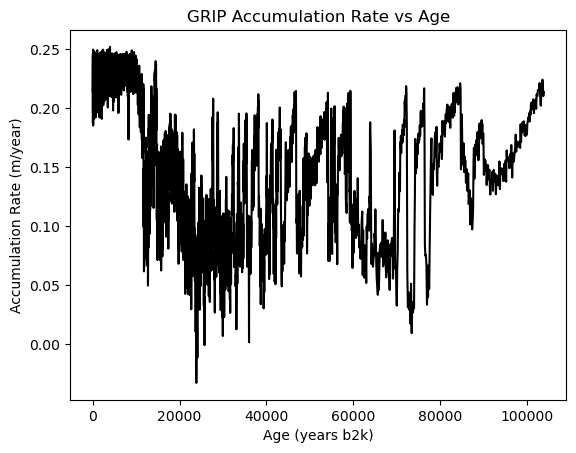

In [67]:
grip_isotope_calc['calc_acc'] = grip_isotope_calc['d18O'].apply(lambda x: a*x**2 + b*x + c) #apply regression
plt.plot(grip_isotope_calc['age'], grip_isotope_calc['calc_acc'], label='Calculated Accumulation Rate', color='black')
plt.xlabel('Age (years b2k)')
plt.ylabel('Accumulation Rate (m/year)')
plt.title('GRIP Accumulation Rate vs Age')

In [63]:
grip_isotope_calc

,depth,age,mce,d18O,calc_acc
0,5.50,20.2,1.0,-36.12,0.214452
1,6.05,21.6,1.0,-36.12,0.214452
2,6.60,22.9,1.0,-34.25,0.238891
3,7.15,24.0,1.0,-35.00,0.230500
4,7.70,25.0,1.0,-34.69,0.234197
...,...,...,...,...,...
5481,3020.05,NaN,NaN,-36.56,0.206995
5482,3020.60,NaN,NaN,-36.48,0.208400
5483,3021.15,NaN,NaN,-35.67,0.221406
5484,3021.70,NaN,NaN,-35.42,0.224975


In [68]:
grip_isotope_calc_export = grip_isotope_calc[['depth', 'calc_acc']].copy(deep=True)
grip_isotope_calc_export.rename(columns={
    'calc_acc': 'deporate'
}, inplace=True)

grip_isotope_calc_export['rel_unc'] = grip_isotope_calc_export['deporate'] * 0.15  # 15% relative uncertainty
grip_isotope_calc_export['comment'] = np.nan

grip_isotope_calc_export.to_csv('/Users/quinnmackay/Desktop/temp/isotope_deporate.txt', sep='\t', index=False)